# RF from Scratch!
- 2 Types of ML modeling techniques primarily used
    - **Decision Tree Ensembles**
        - RF, GBM, XGBoost - easily interpret, quick, but don't extrapolate at all
    - **Neural nets**
        - universal function approximator

#### Imports

In [4]:
%load_ext autoreload
%autoreload 2
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib inline
sys.path.insert(0, "/Users/JI/Documents/Github/fastai_ml/ml1/old/")
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

#### Load data

In [6]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [7]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [8]:
# two cols to start simply
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

#### Basic RF Data Structures
- top down approach

In [9]:
class TreeEnsemble():
    def __init__(self,x,y,n_trees,sample_sz,min_leaf=5):
        np.random.seed(42) # for testing purposes
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
        
    def create_tree(self):
        '''
        Construct a Decision tree from a random sample of the data
        '''
        rndm_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rndm_idxs], self.y[rndm_idxs],
                           idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self,x):
        '''
        The tree ensemble predict function calls each tree's predict function
        (not recursive)
        '''
        return np.mean([t.predict(x) for t in self.trees],axis=0)
    

In [10]:
class DecisionTree():
    def __init__(self,x,y,idxs,min_leaf=5):
        if idxs is None: idxs = np.arange(len(y)) # root of a decision tree contains all the rows
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.rows,self.cols = len(idxs), x.shape[1]
        self.value = np.mean(y[idxs]) # every leaf has a value
        self.score = float('inf')
        self.find_varsplit() # which variable to split on
        
    def find_varsplit(self):
        for i in range(self.cols): self.find_better_split(i)
    
    def find_better_split(self,var_idx): pass
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.rows}; val:{self.value}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s       

In [11]:
# instantiate a TreeEnsemble
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [12]:
m.trees[0]

n: 1000; val:10.079014121552744

In [13]:
m.trees[0].idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 

## Single Branch

In [91]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = ens.trees[0]
x_samp,y_samp = tree.x, tree.y
x_samp.columns


Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [92]:
tree

n: 1000; val:10.079014121552744

**The Scikit learn model to compare our model to**

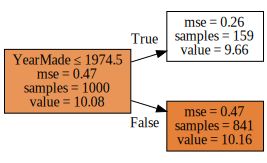

In [103]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [97]:
def find_better_split(self, var_idx):
    '''
    Find which row of the selected column to split the tree on.
    For each row of the selected column, calculate the score (std) 
    for all the corresponding value of the dependent variable on both
    the LHS (<=) or RHS (>) and take the avg of both. Pick the row 
    that has the lowest score
    '''
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]

    for i in range(self.rows):
        lhs = x<=x[i]
        rhs = x>x[i]
        if rhs.sum()<self.min_leaf or lhs.sum()<self.min_leaf: continue
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

### Speeding things up
- computational complexity of find_better_split() is n^2

In [98]:
tree = TreeEnsemble(x_sub,y_train,1,1000).trees[0]

In [99]:
%timeit find_better_split(tree,1)
tree

93.6 ms ± 6.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val:10.079014121552744; score:681.0184057251435; split:3744.0; var:MachineHoursCurrentMeter

In [112]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y,sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt,rhs_sum,rhs_sum2 = self.rows, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

    for i in range(0,self.rows-self.min_leaf):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i<self.min_leaf-1 or xi==sort_x[i+1]:
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,xi

In [113]:
%time find_better_split(tree,1)
tree

CPU times: user 3.89 ms, sys: 567 µs, total: 4.46 ms
Wall time: 4.3 ms


n: 1000; val:10.079014121552744; score:681.0184057251353; split:3744.0; var:MachineHoursCurrentMeter

**can add methods dynamically**

In [114]:
# adding the method defined above to the DecisionTree method
DecisionTree.find_better_split = find_better_split

In [115]:
tree = TreeEnsemble(x_sub,y_train,1,1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

### Full Single Tree

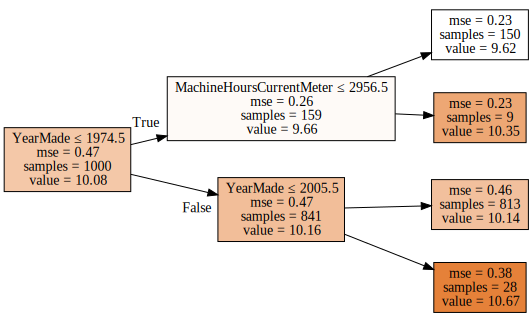

In [133]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [134]:
def find_varsplit(self):
    '''
    Create more decision trees
    '''
    for i in range(self.cols): self.find_better_split(i)
    if self.is_leaf: return
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

In [135]:
DecisionTree.find_varsplit = find_varsplit

In [136]:
tree = TreeEnsemble(x_sub,y_train,1,1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In [137]:
tree.lhs

n: 159; val:9.660892662981706; score:76.82696888346362; split:2800.0; var:MachineHoursCurrentMeter

In [138]:
tree.rhs

n: 841; val:10.158064432982941; score:571.4803525045031; split:2005.0; var:YearMade

In [139]:
tree.lhs.lhs

n: 150; val:9.619280538108496; score:71.15906938383463; split:1000.0; var:YearMade

In [140]:
tree.rhs.rhs

n: 28; val:10.669849650935848; score:16.460871194578985; split:895.0; var:MachineHoursCurrentMeter

### Predictions

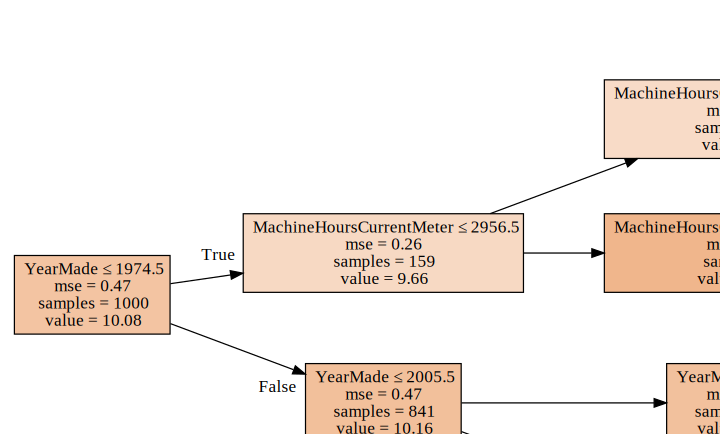

In [141]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [142]:
def predict(self,x): return np.array([self.predict_row(xi) for xi in x])
DecisionTree.predict = predict

In [143]:
def predict_row(self, xi):
    if self.is_leaf: return self.val
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return t.predict_row(xi)

DecisionTree.predict_row = predict_row

In [144]:
%time preds = tree.predict(X_valid[cols].values)

NameError: name 'cols' is not defined

### Quick primer on np.random.permutation


In [8]:
?np.random.permutation

Docstring:
permutation(x)

Randomly permute a sequence, or return a permuted range.

If `x` is a multi-dimensional array, it is only shuffled along its
first index.

.. note::
    New code should use the ``permutation`` method of a ``default_rng()``
    instance instead; see `random-quick-start`.

Parameters
----------
x : int or array_like
    If `x` is an integer, randomly permute ``np.arange(x)``.
    If `x` is an array, make a copy and shuffle the elements
    randomly.

Returns
-------
out : ndarray
    Permuted sequence or array range.

See Also
--------
Generator.permutation: which should be used for new code.

Examples
--------
>>> np.random.permutation(10)
array([1, 7, 4, 3, 0, 9, 2, 5, 8, 6]) # random

>>> np.random.permutation([1, 4, 9, 12, 15])
array([15,  1,  9,  4, 12]) # random

>>> arr = np.arange(9).reshape((3, 3))
>>> np.random.permutation(arr)
array([[6, 7, 8], # random
       [0, 1, 2],
       [3, 4, 5]])
Type:      builtin_function_or_method


In [9]:
a = [1,2,3,4,5]
sample_sz = 3
np.random.permutation(len(a))[:sample_sz]

array([1, 3, 4])

In [15]:
b = np.array([3])

In [11]:
np.array(range(3))

array([0, 1, 2])

In [17]:
b.shape

(1,)

### More thoughts on Extrapolation

In [42]:
x = np.linspace(0,1)
y = x + np.random.uniform(-0.2,0.2,x.shape)
x.shape # tuple with 1 thing in it

(50,)

In [47]:
# rank of a variable is equal to the length of its shape
len(x.shape)

1

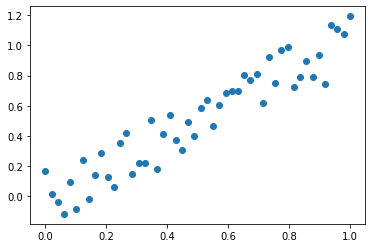

In [43]:
plt.scatter(x,y)

In [46]:
x_trn, x_val = x[:40],x[40:]
y_trn, y_val = y[:40],y[40:]

**None is a special indexer to add rank**

In [48]:
x[None,:].shape

(1, 50)

In [50]:
x[:,None].shape

(50, 1)

In [59]:
x1 = x[...,None]
x1.shape

(50, 1)

In [60]:
x_trn, x_val = x1[:40],x1[40:]
y_trn, y_val = y[:40],y[40:]

In [62]:
m = RandomForestRegressor().fit(x_trn,y_trn)

/Users/JI/miniconda2/envs/fastai_ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


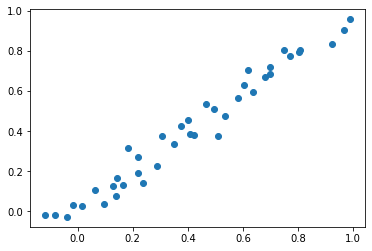

In [64]:
plt.scatter(y_trn, m.predict(x_trn))

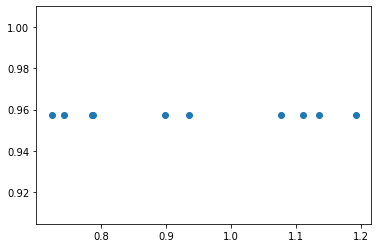

In [65]:
plt.scatter(y_val,m.predict(x_val))

#### The validation set doesn't predict a line!

- RF is just averaging data it's already seen

- previously we avoided time dependent variables

- solutions: 
    - **use a neural net that can approx a function**
    - use a time series model, de-trend it, then use a RF on that
    - gradiant boosting machine
        - still can't extrapolate to the future, but deal with time dependent variables better

## Computational Complexity

Steps:
- is there a loop? (n)
- is there loop inside loop? 
    - if yes multiple by n
    - if no, is there a sort(nlogn)